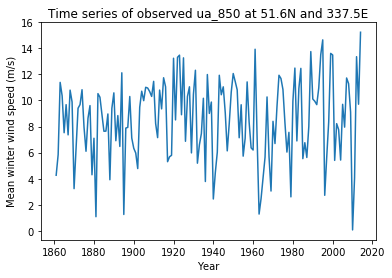

In [37]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

ds_ua850 = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ua850_v2c_185101-201412.nc")
ds_pressure = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ps_v2c_185101-201412.nc")
#the chosen grid point is [time, 0, 13, 120] -> [time, 850.0, 51.6 N, 337.5 E]
#to access year use .dt.year
#print(type(ds_ua850.time[1].dt.year))
local_speed = np.array([])
for i in range(10, 164): #February, 2014 is 1957
    local_speed = np.append(local_speed, [np.average([float(ds_ua850.ua[12*i-1, 0, 13, 120]), \
                                         float(ds_ua850.ua[12*i, 0, 13, 120]), \
                                       float(ds_ua850.ua[12*i+1, 0, 13, 120])])])
    
plt.plot(ds_ua850.time[120:1957:12].dt.year, local_speed)
plt.title('Time series of observed ua_850 at 51.6N and 337.5E')
plt.ylabel('Mean winter wind speed (m/s)')
plt.xlabel('Year')
plt.show()

In [ ]:
import time
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 

start_time = time.time()

lon_ws = np.empty([14])
lat_ws = np.empty([32])
jet_strength = np.empty([154])
jet_latitude = np.empty([154])
NAO_index = np.empty([154])
header_param = "Year\t\tLatitude\tStrength\tNAO_index"

path = "/rds/general/user/ib719/home/UROP_2021/winds.nc"
avg_ws = nc.Dataset(path, 'w', format = 'NETCDF4')
time = avg_ws.createDimension('time', 154)
lat = avg_ws.createDimension('lat', 32)
lon = avg_ws.createDimension('lon', 52)

times = avg_ws.createVariable('time', 'f4', ('time',))
lats = avg_ws.createVariable('lat', 'f4', ('lat',))
lons = avg_ws.createVariable('lon', 'f4', ('lon',))
value = avg_ws.createVariable('value', 'f4', ('time', 'lat', 'lon',))
value.units = 'm/s'
times = ds_ua850.time[120:1957:12].dt.year
lats = ds_ua850.lat[0:32]
lons[0:17] = ds_ua850.lon[0:17]
lons[17:52] = ds_ua850.lon[93:128] 

for i in range(10, 164): # Number of years from 1861 to 2014
    for j in range(0, 32): # Latitude points from 87.9d N to 1.4dN
        for k in range(114, 128): # Longitude points from 300.9d E to 357.2d E 
            # Longitude array of mean winter ws at a j-th latitude
            lon_ws[k-114] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k]])
        lat_ws[j] = np.average(lon_ws) # Latitude array of longitudinal averages
        lon_ws = np.empty([14])
        for k in range(0, 52): # Values for avg_ws.nc
            if k <= 16:
                value[i-10, j, k] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k]])
            else:
                value[i-10, j, k] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k+76]])
    jet_strength[i-10] = max(lat_ws)
    jet_latitude[i-10] = ds_ua850.lat[np.where(lat_ws == max(lat_ws))]
    azores_ps = ds_pressure.ps[(12*i-1):(12*i+2), 8, 121] # Azores DJF
    iceland_ps = ds_pressure.ps[(12*i-1):(12*i+2), 18, 119] # Iceland DJF
    NAO_index[i-10] = np.average(iceland_ps - azores_ps)/100 # Division by 100 to convert into hPa
    lat_ws = np.empty([32])    
    
params = np.column_stack([ds_ua850.time[120:1957:12].dt.year, jet_latitude, jet_strength, NAO_index])
np.savetxt('parameters.txt', params, fmt = '%.5f', delimiter = '\t', header = header_param, comments = '')

plt.xlabel('Year')
plt.ylabel('Jet Strength (m/s)')
plt.title('Jet Strength oscillations (1861-2014)')
plt.plot(ds_ua850.time[120:1957:12].dt.year, jet_strength, color = 'red')
plt.show()
plt.xlabel('Year')
plt.ylabel('Jet Latitude (deg)')
plt.title('Jet Latitude oscillations (1861-2014)')
plt.plot(ds_ua850.time[120:1957:12].dt.year, jet_latitude, color = 'green')
plt.show()
plt.xlabel('Year')
plt.ylabel('NAO point index (hPa)')
plt.title('Variation of NAO index (1861-2014)')
plt.plot(ds_ua850.time[120:1957:12].dt.year, NAO_index, color = 'blue')
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [26]:
""" Regression Analysis """
import time
import scipy as sp
from scipy import signal 
import netCDF4 as nc

# jet_stength2 = signal.detrend(jet_strength)
# jet_latitude2 = signal.detrend(jet_latitude)
# NAO_index2 = signal.detrend(NAO_index)

'''
def wind_index(lat, lon):
    if lon < 52 and lat < 32:
        return lat*52 + lon
    else: print('Error: Corrdinates are out of bounds')
    
# Arranging wind speed in a txt file
for j in range(0, 32): # from 0 to 45E 
    for k in range(0, 52):
        temporary_ws = np.empty([154])
        for i in range(10, 164):
            if k <= 16:
                temporary_ws[i-10] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k]])
            else:
                temporary_ws[i-10] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k+76]])
        avg_ws[wind_index(j, k)] = temporary_ws
        if j == 0 and k == 0:
            continue
        else:
            header_ws += '%d/%d\t' % (j, k)
            
avg_ws = np.transpose(avg_ws)
np.savetxt('wind_speed.txt', avg_ws, fmt = '%.5f', delimiter = '\t', header = header_ws, comments = '')
''' 

start_time = time.time()
'''
years, jet_latitude, jet_strength, NAO_index = np.loadtxt("Parameters.txt", skiprows = 1, unpack = True)
jet_stength_de = signal.detrend(jet_strength)
jet_latitude_de = signal.detrend(jet_latitude)
NAO_index_de = signal.detrend(NAO_index)

avg_ws = np.loadtxt("wind_speed.txt", skiprows = 1, unpack = True)


fit1, cov1 = sp.polyfit(x1[0], y1[0], 1, cov = True) #1 stands for the degree of a polynomial 
fit2, cov2 = sp.polyfit(x2[0], y2[0], 1, cov = True)

print(fit1[0], ' & ', fit2[0])
y3 = signal.detrend(y2)
'''
print("--- %s seconds ---" % (time.time() - start_time))

(-0.7006558807032567, ' & ', -0.7006558807032559)
(array([[ 1.58088578, -0.3404862 , -0.94223509,  0.39189807, -0.49330999,
        -1.05703653,  0.4409582 ,  1.42090073,  0.39975073, -2.90134779]]), array([[ 1.58088578, -0.3404862 , -0.94223509,  0.39189807, -0.49330999,
        -1.05703653,  0.4409582 ,  1.42090073,  0.39975073, -2.90134779]]))


In [59]:
a = [[1.52, 2.13, 3.13], [4.2542, 5.00, 6.777], [3, 5, 6], [8, 6, 9]]
a = np.transpose(a)
np.savetxt('data.txt', a, fmt = '%.2f', delimiter = '\t', header = "HDA\t\tZeff\tchicha\treal", comments = '')

In [53]:
import xarray as xr
import netCDF4 as nc
import numpy as np
#import h5py
#ds_pressure = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ps_v2c_185101-201412.nc")
#test = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/winds.nc")

fn = '/rds/general/user/ib719/home/UROP_2021/test.nc'
#test = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/test.nc")

ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', None)
lat = ds.createDimension('lat', 10)
lon = ds.createDimension('lon', 10)

times = ds.createVariable('time', np.float32, ('time',))
lats = ds.createVariable('lat', np.float32, ('lat',))
lons = ds.createVariable('lon', np.float32, ('lon',))
value = ds.createVariable('value', np.float64, ('time', 'lat', 'lon',))
value.units = 'Unknown'

lats[:] = np.arange(40.0, 50.0, 1.0)
lons[:] = np.arange(-110.0, -100.0, 1.0)

print('var size before adding data', value.shape)
value[0, :, :] = np.random.uniform(0, 100, size=(10, 10))
value[1, :, :] = np.random.uniform(0, 100, size=(10, 10))

ds.close()

('var size before adding data', (0, 10, 10))


In [ ]:
strength_monthly = np.empty([3])
lat_monthly = np.empty([3])
for i in range(10, 164): # Number of years from 1861 to 2014
    for j in range(0, 32): # Latitude points from 87.9d N to 1.4dN
        for k in range(114, 128): # Longitude points from 300.9d E to 357.2d E 
            # Longitude array of mean winter ws at a j-th latitude
            lon_ws_D[k-114] = ds_ua850.ua[(12*i-1), 0, j, k]]
            lon_ws_J[k-114] = ds_ua850.ua[(12*i), 0, j, k]]
            lon_ws_F[k-114] = ds_ua850.ua[(12*i+1), 0, j, k]]
        lat_ws_D[j] = np.average(lon_ws_D) # Latitude array of longitudinal monthly values
        lat_ws_J[j] = np.average(lon_ws_J)
        lon_ws_F[j] = np.average(lon_ws_F)
        lon_ws_D = np.empty([14])
        lon_ws_F = np.empty([14])
        lon_ws_J = np.empty([14])
        for k in range(0, 52): # Values for avg_ws.nc
            if k <= 16:
                value[i-10, j, k] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k]])
            else:
                value[i-10, j, k] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k+76]])
    jet_strength[i-10] = np.average([max(lat_ws_D), max(lat_ws_J), max(lat_ws_F)])
    jet_latitude[i-10] = np.average([ds_ua850.lat[np.where(lat_ws_D == max(lat_ws_D))], \
                                     ds_ua850.lat[np.where(lat_ws_J == max(lat_ws_J))], \
                                     ds_ua850.lat[np.where(lat_ws_F == max(lat_ws_F))]])
    azores_ps = ds_pressure.ps[(12*i-1):(12*i+2), 8, 121] # Azores DJF
    iceland_ps = ds_pressure.ps[(12*i-1):(12*i+2), 18, 119] # Iceland DJF
    NAO_index[i-10] = np.average(iceland_ps - azores_ps)/100 # Division by 100 to convert into hPa
    lat_ws_D = np.empty([32])  
    lat_ws_J = np.empty([32])  
    lat_ws_F = np.empty([32])  